In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from piflib.data_util import calculate_distribution
from tutorial_helpers import horizontal_bar_plot, compute_posterior_distributions
import piflib

# _Cell surprise factor_ (CSF) as a measure of information risk

The cell information gain (CIG), as introduced in the ACS data sharing white paper, offers a novel way to reason about
the personal information contained in a dataset. By measuring the personal information factor on a cell level, an
analyst is able to quickly locate the areas in the dataset that need the most attention.

However, we identified two problems with this approach and propose a new measure to address those issues.

### Problem 1: overcounting

The CIG is defined as the KL-divergence of the prior distribution of the feature and the posterior of that feature,
given all other features. This means though that the CIG value is a measure of surprise of how the distribution of the
values changed, i.e., a combination of **all** the values in the posterior distribution. Thus, the CIG is not really a
fair representation of the risk of the single cell value, but rather represents the risk of that feature for the cohort
comprising that particular posterior distribution.

For example, consider the following dataset:


In [2]:
data = {'A': ['a', 'a', 'a', 'b', 'b', 'c', 'c', 'c', 'c'],
        'B': ['g', 'h', 'i', 'g', 'g', 'h', 'h', 'h', 'i']}
df = pd.DataFrame(data)
df

,A,B
0,a,g
1,a,h
2,a,i
3,b,g
4,b,g
5,c,h
6,c,h
7,c,h
8,c,i


The prior distributions for the features 'A' and 'B' look like this:

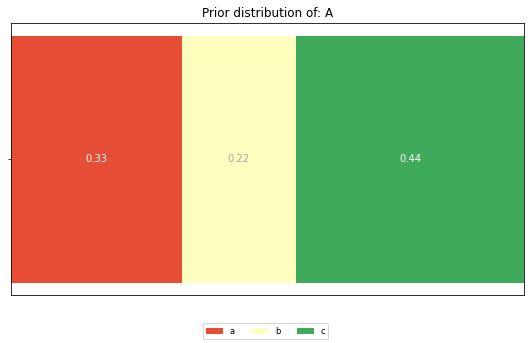

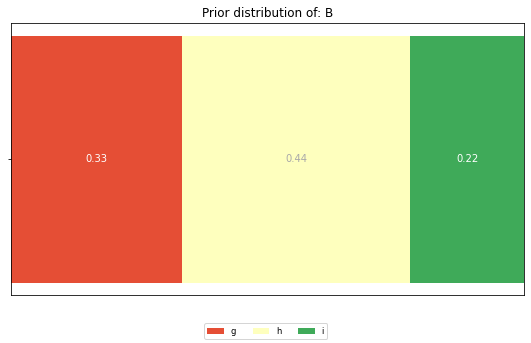

In [3]:
for feature in df.columns:
    dist = calculate_distribution(df[feature])
    horizontal_bar_plot({'': list(dist.values())}, dist.keys())
    plt.title(f'Prior distribution of: {feature}')



And these are the posterior distributions:

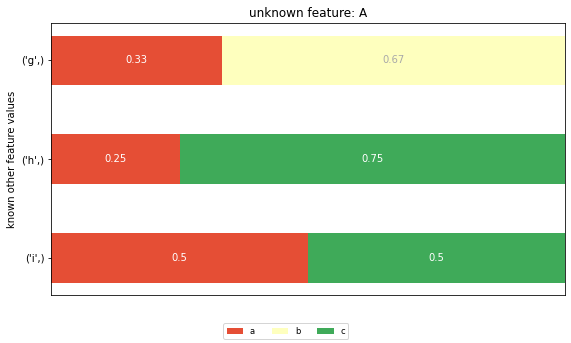

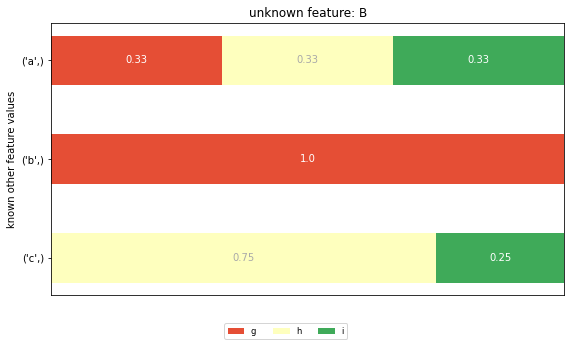

In [4]:
for feature in df.columns:
    

    horizontal_bar_plot(*compute_posterior_distributions(feature, df))
    plt.title(f'unknown feature: {feature}')
    plt.ylabel('known other feature values')
    plt.show()

The CIG value for row 0, feature 'A' is computed as the KL divergence between the prior distribution for feature 'A'
and the posterior distribution for the unknown feature 'A' and given value 'g' (the first row in the posterior
distribution graph).
The KL divergence is defined as a weighted sum of the logarithmic differences of **all** corresponding elements in
prior and posterior distribution.
This leads to two potential problems:
- The CIG value measures the element of surprise of the **combined** set of possible cell values in the posterior
  distribution, thus overestimating the real element of surprise of a single cell value.
- All cell values of a feature with the same posterior distribution get assigned the same CIG value, irrespective of
  their individual change in probability.


### Problem 2: unbounded CIG values
The KL divergence has no upper bound. This makes it hard to find an acceptance threshold for which to consider the
data to be safe.

## Cell Surprise Factor (CSF), an alternative measure of surprise

The underlying idea of the CIG is to measure the element of surprise of a cell value when its context
changes -- suppose we know every cell value of a person but one, how  surprising is this value compared to what we
previously though about it?

What if instead, we measure the change of probabilities of the cell value between prior and posterior distribution?
Compute prior and posterior as before, but now look at how the probability of the cell value changes between those two distributions.

## Example
For our dataset from before, the CSF values are as follows:

<AxesSubplot:>

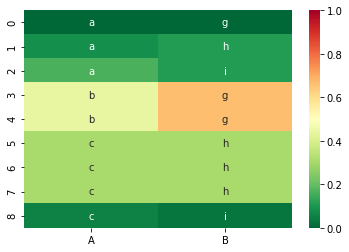

In [5]:
df_csf = piflib.compute_csfs(df)
color_map = matplotlib.colors.ListedColormap(
        sns.color_palette("RdYlGn", 256).as_hex()[::-1])
sns.heatmap(df_csf, vmin=0, vmax=1, cmap=color_map, annot=df, fmt='s')

And the corresponding CIG values:

<AxesSubplot:>

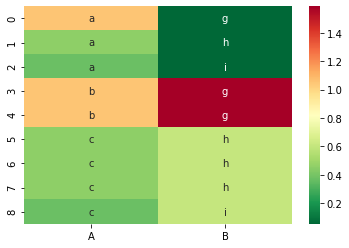

In [6]:
df_cig = piflib.compute_cigs(df)
sns.heatmap(df_cig, cmap=color_map, annot=df, fmt='s')

Here I want to highlight the difference between CIG and CSF.
The probability of the first cell value, the 'a' in row 0 is 1/3 in the distribution of the feature 'A'.
In the posterior distribution of 'A' given 'B' = 'g' the probability for 'a' stays the same at 1/3. However, the
probability for 'b' changes from 2/9 to 2/3, the one for 'c' from 4/9 to 0.

This in turn means that the CIG value will be > zero, as the posterior is different from the prior distribution, but
the CSF value is 0, as the probability of 'a' did not change between the two distributions.

We argue that the CSF is a better measure of surprise for a cell value, as it reflects the change, or surprise, of the
cell value alone, without interference of the other elements in the posterior.

In the case above, as the probability for 'A' does not change, there is no element of surprise.
However, as the two distributions are different, the KL divergence will be greater than zero, thus falsely indicating
that the 'A' value in row 0 is unusual.

## Going bigger - hackathon dataset

In [7]:
hack_features = ['gender', 'AGE', 'POSTCODE', 'blood_group', 'eye_color', 'job']
hack_data = pd.read_csv('data/hackathon.csv')[hack_features]
hack_data = hack_data.fillna('Unemployed')
hack_data.head()

,gender,AGE,POSTCODE,blood_group,eye_color,job
0,F,99,2649,B-,Brown,"Psychologist, counselling"
1,M,108,1780,A-,Hazel,Personnel officer
2,M,59,2940,B+,Hazel,Tourism officer
3,M,58,2945,B+,Blue,Make
4,M,30,2729,AB-,Brown,Forest/woodland manager


We now compute the CSF values and display them as a heatmap, with colors ranging from green for 'save' values to red for the most at risk values.

<AxesSubplot:>

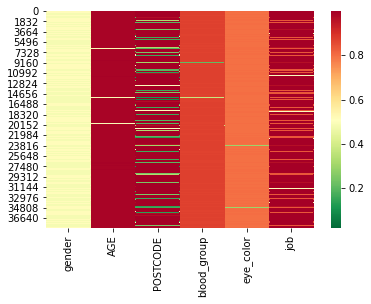

In [8]:
hack_csf = piflib.compute_csfs(hack_data)
sns.heatmap(hack_csf, cmap=color_map)

Looking at the distribution of CSF values, we can see that the changes are quite substantial.

In [9]:
hack_csf.describe()

,gender,AGE,POSTCODE,blood_group,eye_color,job
count,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000
mean,0.498328,0.977707,0.846887,0.869045,0.795840,0.966596
std,0.028408,0.086362,0.307341,0.056100,0.045859,0.074689
min,0.017524,0.133263,0.049805,0.073070,0.131810,0.331747
25%,0.482476,0.990952,0.996880,0.873252,0.798502,0.998414
50%,0.482476,0.991394,0.997660,0.874682,0.800348,0.998648
75%,0.517524,0.991654,0.999740,0.876007,0.801232,0.998804
max,0.517524,0.999740,0.999974,0.877047,0.801440,0.999402


CSF values range from 0 to 1, where 0 stands for no surprise and 1 for maximum surprise (or difference from the prior believe). We can see that the mean CSF values are very high. This is due to the fact that almost every row is unique, thus forming mostly cohorts of 1 for the posterior distributions.

Let's try to reduce the numbers by removing the features 'job' and 'POSTCODE'.

<AxesSubplot:>

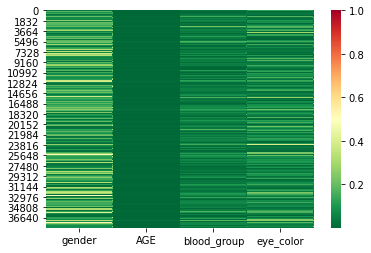

In [10]:
cols = ['gender', 'AGE', 'blood_group', 'eye_color']
sub_hack_csf = piflib.compute_csfs(hack_data[cols])
sns.heatmap(sub_hack_csf, cmap=color_map, vmax=1)

In [12]:
sub_hack_csf.describe()

,gender,AGE,blood_group,eye_color
count,38462.000000,38462.000000,38462.000000,38462.000000
mean,0.136386,0.003600,0.048995,0.072766
std,0.104873,0.003025,0.041834,0.059569
min,0.006286,0.000001,0.000305,0.000348
25%,0.053905,0.001375,0.018391,0.027585
50%,0.117524,0.002807,0.039136,0.058666
75%,0.184190,0.005016,0.069355,0.103322
max,0.517524,0.022063,0.877047,0.801440


This already looks a lot better. The mean CSF values are very low now. However, there are some rows in the dataset with
high CSF values. These rows still stand out and thus have a higher risk of re-identification.

## Conclusions

The CSF, defined as the absolute difference between two probabilities, is always bounded between 0 and 1. Thus, we have
fixed bounds and might be able to transfer learnings from one dataset to another more easily.

The CSF measures the element of surprise of a single cell value, whereas the CIG measures the element of surprise of the
posterior distribution. We believe that the CSF provides are finer granular, and true-er, picture of the element of
surprise of a cell value contained in a dataset.

